In [2]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

In [3]:
qof_df = pd.read_csv("Combined QOF data 2015_19.csv")

In [4]:
qof_df.head()

,date,region_code,region_ons_code,region_name,regional_local_office_code,regional_local_office_ons_code,regional_local_office_name,ccg_code,ccg_ons_code,ccg_name,...,register,prevalence_(%),(max_2_per_practice),numerator,denominator,net_of_exceptions_(%),exceptions,exception_rate_(%),plus_exceptions,intervention_(%)
0,2018/9,Y56,E40000003,London,Q71a,E39000018,London North East and Central,07M,E38000005,NHS Barnet CCG,...,172,2.21,1.50,8,10,80.0,1,9.09,11,72.73
1,2018/9,Y56,E40000003,London,Q71a,E39000018,London North East and Central,07M,E38000005,NHS Barnet CCG,...,116,1.27,2.00,3,3,100.0,2,40.00,5,60.00
2,2018/9,Y56,E40000003,London,Q71a,E39000018,London North East and Central,07M,E38000005,NHS Barnet CCG,...,46,0.78,1.88,7,8,87.5,0,0.00,8,87.50
3,2018/9,Y56,E40000003,London,Q71a,E39000018,London North East and Central,07M,E38000005,NHS Barnet CCG,...,103,1.21,2.00,7,7,100.0,0,0.00,7,100.00
4,2018/9,Y56,E40000003,London,Q71a,E39000018,London North East and Central,07M,E38000005,NHS Barnet CCG,...,56,0.62,2.00,1,1,100.0,0,0.00,1,100.00


In [5]:
qof_df.columns

Index(['date', 'region_code', 'region_ons_code', 'region_name',
       'regional_local_office_code', 'regional_local_office_ons_code',
       'regional_local_office_name', 'ccg_code', 'ccg_ons_code', 'ccg_name',
       'practice_code', 'practice_name', 'list_size', 'register',
       'prevalence_(%)', '(max_2_per_practice)', 'numerator', 'denominator',
       'net_of_exceptions_(%)', 'exceptions', 'exception_rate_(%)',
       'plus_exceptions', 'intervention_(%)'],
      dtype='object')

In [6]:
#generate smaller table using just the columns I want.  Plus_exceptions is the column with the denominator plus exceptions figure
a = ['date', 'ccg_code', 'ccg_name', 'practice_code', 'list_size', 'plus_exceptions']
new_qof_df = qof_df[a].reset_index(drop=True)
new_qof_df.head()

,date,ccg_code,ccg_name,practice_code,list_size,plus_exceptions
0,2018/9,07M,NHS Barnet CCG,E83027,7794,11
1,2018/9,07M,NHS Barnet CCG,E83044,9121,5
2,2018/9,07M,NHS Barnet CCG,E83600,5878,8
3,2018/9,07M,NHS Barnet CCG,E83621,8547,7
4,2018/9,07M,NHS Barnet CCG,E83637,9071,1


(20000, 50000)

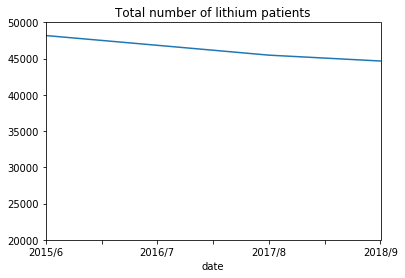

In [7]:
# generate graph showing change in QOF patient numbers over time (apr2015-Sep2018)
plot1 = qof_df.groupby("date")['plus_exceptions'].sum().plot(kind='line', title="Total number of lithium patients")
plt.ylim(20000, 50000)

In [8]:
# calculate patients per 1000 list size

#first convert both lists to floats
new_qof_df['plus_exceptions'] = new_qof_df['plus_exceptions'].astype(float)
new_qof_df['list_size'] = new_qof_df['list_size'].astype(float)

#then calculate patients per 1000 list_size
new_qof_df['litpts_per_1000'] = 1000* (new_qof_df['plus_exceptions']/new_qof_df['list_size'])
new_qof_df.head(-20)


,date,ccg_code,ccg_name,practice_code,list_size,plus_exceptions,litpts_per_1000
0,2018/9,07M,NHS Barnet CCG,E83027,7794.0,11.0,1.411342
1,2018/9,07M,NHS Barnet CCG,E83044,9121.0,5.0,0.548186
2,2018/9,07M,NHS Barnet CCG,E83600,5878.0,8.0,1.361007
3,2018/9,07M,NHS Barnet CCG,E83621,8547.0,7.0,0.819001
4,2018/9,07M,NHS Barnet CCG,E83637,9071.0,1.0,0.110241
...,...,...,...,...,...,...,...
28959,2015/6,99N,NHS WILTSHIRE CCG,J83045,8688.0,9.0,1.035912
28960,2015/6,99N,NHS WILTSHIRE CCG,J83046,11179.0,14.0,1.252348
28961,2015/6,99N,NHS WILTSHIRE CCG,J83048,5146.0,2.0,0.388651
28962,2015/6,99N,NHS WILTSHIRE CCG,J83049,11278.0,13.0,1.152687


In [9]:
# download prescribing dataset as before

sql2 = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030K0%", items,0)) AS carbonate,
sum(IF(rx.bnf_code LIKE "0402030P0%", items,0)) AS citrate,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting = 4
  AND (bnf_code LIKE "0402030K0%" OR ##carbonate
  bnf_code LIKE "0402030P0%") ##citrate
  AND
ccgs.org_type='CCG'
GROUP BY
rx.month,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_lithium = bq.cached_read(sql2, csv_path='lithium.csv')

In [10]:
df_lithium.head()

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01 00:00:00+00:00,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01 00:00:00+00:00,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01 00:00:00+00:00,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01 00:00:00+00:00,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01 00:00:00+00:00,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [11]:
df_lithium['month'] = df_lithium['month'].astype('datetime64[ns]')
df_lithium.head()

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [12]:
df_lithium['month'] = pd.to_datetime(df_lithium['month'])

## Show plot of QOF patient numbers v Avg. Monthly No Lithium Items

QOF data is a yearly sample, therefore need to compare against an average month of prescribing items from each practice.  Plan to show data for each year of QOF data extracted.



In [13]:
## 2015-2016 data
#First choose prescribing data from Apr 15 to Mar 16.  
mask1 = (df_lithium['month'] >= "2015-04-01") & (df_lithium['month'] <= "2016-03-31")
df_1516 = df_lithium.loc[mask1]
df_1516.head()


,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
426092,2015-04-01,E87043,08Y,0402030K0,Lithium Carbonate,2,0,2,3.70
426093,2015-04-01,M91004,05Y,0402030K0,Lithium Carbonate,2,0,2,1.68
426094,2015-04-01,D83060,07K,0402030K0,Lithium Carbonate,86,0,86,72.50
426095,2015-04-01,C87604,03L,0402030K0,Lithium Carbonate,7,0,7,9.61
426096,2015-04-01,B83011,02W,0402030K0,Lithium Carbonate,10,0,10,8.21


In [27]:
#Add all columns to show annual data per practice for 2015/6
df_annual1516 = df_1516.groupby('practice').sum()

df_annual1516.head()

,carbonate,citrate,total_lithium,total_cost
practice,,,,
A81001,80,0,80,135.74
A81002,318,0,318,683.13
A81004,41,0,41,52.67
A81005,202,0,202,286.84
A81006,265,0,265,705.59


In [28]:
#Next choose just 15/16 data from the QOF table
df_QOF1516 = new_qof_df[new_qof_df['date'] == "2015/6"].reset_index(drop=True)
df_QOF1516.head()

,date,ccg_code,ccg_name,practice_code,list_size,plus_exceptions
0,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82007,9463,17
1,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82020,12121,23
2,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82028,14097,34
3,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82053,11859,18
4,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B83002,4368,4


In [29]:
#Merge this abridged 15/16 prescribing dataset with the 15/16 QOF data
df_1516merge = pd.merge(df_QOF1516, df_annual1516, how='outer', left_on='practice_code', right_on='practice')
df_1516merge.head()

,date,ccg_code,ccg_name,practice_code,list_size,plus_exceptions,carbonate,citrate,total_lithium,total_cost
0,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82007,9463.0,17.0,272.0,0.0,272.0,396.09
1,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82020,12121.0,23.0,365.0,12.0,377.0,654.78
2,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82028,14097.0,34.0,683.0,11.0,694.0,981.22
3,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82053,11859.0,18.0,270.0,0.0,270.0,451.44
4,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B83002,4368.0,4.0,96.0,0.0,96.0,87.58


In [30]:
#choose the columns of data that I want
b = ['date', 'ccg_code', 'ccg_name', 'practice_code', 'list_size', 'plus_exceptions', 'total_lithium']
df_1516data = df_1516merge[b].reset_index(drop=True)
df_1516data.head()

,date,ccg_code,ccg_name,practice_code,list_size,plus_exceptions,total_lithium
0,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82007,9463.0,17.0,272.0
1,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82020,12121.0,23.0,377.0
2,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82028,14097.0,34.0,694.0
3,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82053,11859.0,18.0,270.0
4,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B83002,4368.0,4.0,96.0


In [31]:
#Show average monthly items for each practice
df_1516data['avg_item_per_month'] = round(df_1516data['total_lithium'] / 12)
df_1516data.head()

,date,ccg_code,ccg_name,practice_code,list_size,plus_exceptions,total_lithium,avg_item_per_month
0,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82007,9463.0,17.0,272.0,23.0
1,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82020,12121.0,23.0,377.0,31.0
2,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82028,14097.0,34.0,694.0,58.0
3,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B82053,11859.0,18.0,270.0,22.0
4,2015/6,02N,"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",B83002,4368.0,4.0,96.0,8.0


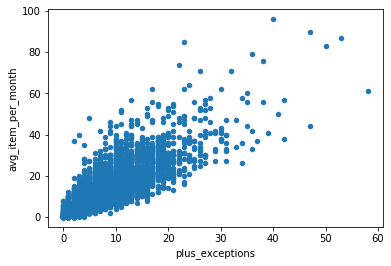

In [32]:
#Plot graph to compare the number of patients per practice ('plus_exceptions') to the average monthly number of items dispensed

plot2 = df_1516data.plot.scatter("plus_exceptions", 'avg_item_per_month')


(0, 40)

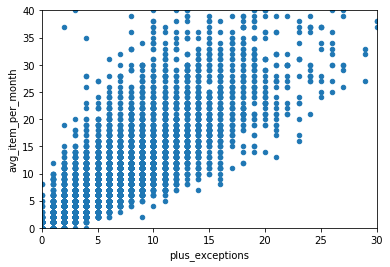

In [33]:
plot3 = df_1516data.plot.scatter("plus_exceptions", 'avg_item_per_month')
plt.xlim(0,30)
plt.ylim(0,40)

In [21]:
#Demonstrate same data from CCG perspective.  Table shows for each CCG; the list_size in 2015/6, the total number of lithium denominators plus exceptions in 2015/6, the total number of lithium items dispensed in 2015/6 and the average number of lithium items per month.

df_CCGview = df_1516data.groupby('ccg_name').sum()
df_CCGview.head()



,list_size,plus_exceptions,total_lithium,avg_item_per_month
ccg_name,,,,
"NHS AIREDALE, WHARFEDALE AND CRAVEN CCG",158139.0,200.0,3552.0,295.0
NHS ASHFORD CCG,128891.0,66.0,1183.0,100.0
NHS AYLESBURY VALE CCG,208721.0,216.0,3136.0,259.0
NHS BARKING AND DAGENHAM CCG,207968.0,93.0,2087.0,173.0
NHS BARNET CCG,403060.0,324.0,4867.0,405.0


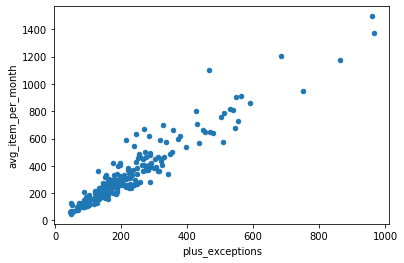

In [22]:
plot4 = df_CCGview.plot.scatter("plus_exceptions", 'avg_item_per_month')

#This shows there are a couple of outliers where avg number of items dispensed far exceeds the number of registered lithium patients.  
#Note this does not take into account the size of the CCG therefore large figures may simply represent large populations.